In [1]:
import os 
import sys 
import random 
from importlib import reload as rl
import numpy as np 
import cv2 
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras 
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import keras 

from datagen import DataGen
from models_2 import UNet
from loss_functions import *

seed = 2019
random.seed = seed
np.random.seed = seed 
tf.seed = seed 

# tf.debugging.set_log_device_placement(False)


In [2]:
def get_ids():
    ids = []
    for _, _, files in os.walk(path+input_path):
        for filename in files:
            ids.append(filename[14:-4])
    return ids


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
image_size = 512 
epochs = 40
batch_size = 2
path = f"data_{str(image_size)}_clean/"
input_path = "input/"
mask_path = "masks/"
ids = get_ids()
train_ids, valid_ids = train_test_split(ids, test_size = 0.2)

[[[103 111 118]
  [110 118 125]
  [115 123 130]
  ...
  [161 162 160]
  [162 166 161]
  [160 164 159]]

 [[103 111 118]
  [106 114 121]
  [109 117 124]
  ...
  [162 163 161]
  [164 168 163]
  [164 168 163]]

 [[103 113 120]
  [101 111 118]
  [101 111 118]
  ...
  [166 167 163]
  [168 169 165]
  [169 170 166]]

 ...

 [[ 91 108  97]
  [ 85 105  93]
  [ 85 105  93]
  ...
  [ 60  93  96]
  [ 64  97 100]
  [ 72 106 106]]

 [[ 92 107  99]
  [ 91 108  97]
  [ 90 107  96]
  ...
  [ 73 105 110]
  [ 74 109 112]
  [ 82 116 116]]

 [[ 89 104  96]
  [ 93 108 100]
  [ 94 111 100]
  ...
  [ 73 106 109]
  [ 85 118 121]
  [ 88 122 122]]]


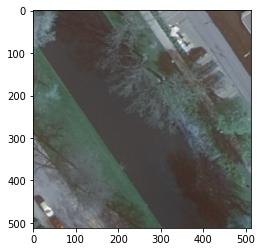

In [5]:
i = 117
img = cv2.imread(f'{os.path.join(path, input_path, "")}luchtfoto2019_{i}.tif', -1)
plt.imshow(img)
print(img)
mask = cv2.imread(f'{os.path.join(path, mask_path, "")}Waterdeel_{i}.tif', 0)


In [6]:
train_gen = DataGen(train_ids, path, input_path, mask_path, batch_size = batch_size, image_size = image_size)
x = train_gen.__getitem__(0)
print(x)

(array([[[[0.32156864, 0.3254902 , 0.34117648],
         [0.34117648, 0.3529412 , 0.36862746],
         [0.36078432, 0.37254903, 0.3882353 ],
         ...,
         [0.42352942, 0.4627451 , 0.4392157 ],
         [0.44313726, 0.48235294, 0.45882353],
         [0.41568628, 0.47058824, 0.44705883]],

        [[0.30588236, 0.30980393, 0.3254902 ],
         [0.32156864, 0.3254902 , 0.34117648],
         [0.3529412 , 0.3647059 , 0.38039216],
         ...,
         [0.42745098, 0.46666667, 0.44313726],
         [0.44313726, 0.48235294, 0.45882353],
         [0.43529412, 0.48235294, 0.45882353]],

        [[0.31764707, 0.3254902 , 0.32941177],
         [0.31764707, 0.3254902 , 0.32941177],
         [0.34509805, 0.35686275, 0.37254903],
         ...,
         [0.40784314, 0.44705883, 0.42352942],
         [0.42352942, 0.45882353, 0.44705883],
         [0.42352942, 0.46666667, 0.45490196]],

        ...,

        [[0.6156863 , 0.67058825, 0.73333335],
         [0.64705884, 0.69411767, 0.7490196 

In [7]:
model_size = [256, 512]
batch_sizes = [4,6,8]
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
batch_norms = [True, False]
run_nr = 1
model = UNet(256, image_size, dropout=0.1)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=bce_dice_loss, metrics=['acc', tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])


train_gen = DataGen(train_ids, path, input_path, mask_path, batch_size = batch_size, image_size = image_size)
valid_gen = DataGen(valid_ids, path, input_path, mask_path, batch_size = batch_size, image_size = image_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.fit(train_gen, validation_data=valid_gen, epochs=epochs, callbacks = [callback])


model.save("UNetW_3.h5")

Epoch 1/40
 152/2544 [>.............................] - ETA: 3:31 - loss: 1.2835 - acc: 0.6795 - mean_io_u: 0.3361 - dice_coef: 0.3306 - recall: 0.0451 - precision: 0.6658

KeyboardInterrupt: 

In [ ]:

## Dataset for prediction
x, y = valid_gen.__getitem__(6)
result = model.predict(x)
result = result[0]

In [ ]:
plt.imshow(x[0])

In [ ]:
plt.imshow(y[0])

In [ ]:

y_pred = np.where(result > 0.95, 1, 0)
plt.imshow(y_pred)
y_pred